In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import matplotlib
import scipy as sp
import IPython
import sklearn
import random
import time
import warnings
# warnings.filterwarnings('ignore')
print(f"Python version: {sys.version}")
print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"scipy version: {sp.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print('-'*25)
from pandas_profiling import ProfileReport

iofile = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        iofile.append(os.path.join(dirname, filename))

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
pandas version: 1.3.5
NumPy version: 1.21.6
scipy version: 1.7.3
matplotlib version: 3.5.3
-------------------------
/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
print(f"input file: {iofile}")
rawdata = pd.read_csv(iofile[0])

input file: ['/kaggle/input/pima-indians-diabetes-database/diabetes.csv']


# Data Analysis

In [3]:
print('\033[0m\033[94m*' * 21)
print('\033[94m\033[1m'+'.: Train Dataset :.')
print('\033[0m\033[94m*' * 21)
rawdata.head().style.background_gradient(cmap="Greens").set_properties(**{'font-family': 'Segoe UI'}).hide_index()

*********************
.: Train Dataset :.
*********************


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.600000,0.627000,50,1
1,85,66,29,0,26.600000,0.351000,31,0
8,183,64,0,0,23.300000,0.672000,32,1
1,89,66,23,94,28.100000,0.167000,21,0
0,137,40,35,168,43.100000,2.288000,33,1


In [4]:
ProfileReport(rawdata, title='Train Dataset', minimal=True, progress_bar=False, 
              samples=None, correlations=None, interactions=None, explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}},
              html={'style':{'primary_color': '#219EBC'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

**ALerts를 통해서 확인할 수 있었던 것들**

* Pregnancies가 alert로 떳지만 원래 아이를 갖지 않는 사람이 있는 것일 수도 있어서 누락됐는지 아이를 갖지 않은건지 모른다. -> 누락과 실제값이 0인 것이 섞임.
* BloodPressure는 누락된게 맞다. 4.6%가 누락됨.
* SkinThicknesss는 애초에 0인가 싶었는데 분포를 보니까 누락된게 맞음. 29.6%가 누락됨.
* Insulin도 누락됨 -> 48.7%
* BMI도 누락됨 -> 1.4%
* DiabetesPedigreeFunction는 누락된게 없음.
* Age는 누락된게 없음. -> 근데 압도적으로 20살? 21살?인 사람이 많은 것으로 보아 data collection자체가 잘못됐거나 그냥 20살아래를 그냥 다 같이 뭉뚱거려서 20살이라고 한건가? data의 부정확성이 결과에 안좋게 영향을 끼칠 수 있음. 하지만 나이가 적어서 별로 영향을 끼치지 않을수도.

채워넣어야할 data들이 많음.

***Q. 채우지 않고 진행할 수 있는 방법이 존재하는가?***

# Data Cleaning: 데이터 완성하기

In [5]:
avgBP = rawdata['BloodPressure'][rawdata['BloodPressure'] != 0].mean()
avgST = rawdata['SkinThickness'][rawdata['SkinThickness'] != 0].mean()
avgIL = rawdata['Insulin'][rawdata['Insulin'] != 0].mean()
avgBMI = rawdata['BMI'][rawdata['BMI'] != 0].mean()

print(f"avgBP: {avgBP:.2f}")
print(f"avgST: {avgST:.2f}")
print(f"avgIL: {avgIL:.2f}")
print(f"avgBMI: {avgBMI:.2f}")

avgBP: 72.41
avgST: 29.15
avgIL: 155.55
avgBMI: 32.46


In [6]:
data = rawdata.copy()

data.at[data['BloodPressure'] == 0,'BloodPressure'] = avgBP
data.at[data['SkinThickness'] == 0,'SkinThickness'] = avgST
data.at[data['Insulin'] == 0,'Insulin'] = avgIL
data.at[data['BMI'] == 0,'BMI'] = avgBMI

In [7]:
ProfileReport(data, title='Train Dataset', minimal=True, progress_bar=False, 
              samples=None, correlations=None, interactions=None, explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}},
              html={'style':{'primary_color': '#219EBC'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

# Data Splitting

In [8]:
# Divide Train and Test Dataset

varNames = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
tarName = ['Outcome']
train_x, test_x, train_y, test_y = model_selection.train_test_split(data[varNames],data[tarName], random_state=43)
print(f"train_x.shape: {train_x.shape}")
print(f"test_x.shape: {test_x.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"test_y.shape: {test_y.shape}")
train_x.head()

train_x.shape: (576, 8)
test_x.shape: (192, 8)
train_y.shape: (576, 1)
test_y.shape: (192, 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
547,4,131,68.0,21.00000,166.000000,33.1,0.160,28
404,5,168,64.0,29.15342,155.548223,32.9,0.135,41
12,10,139,80.0,29.15342,155.548223,27.1,1.441,57
310,6,80,66.0,30.00000,155.548223,26.2,0.313,41
419,3,129,64.0,29.00000,115.000000,26.4,0.219,28


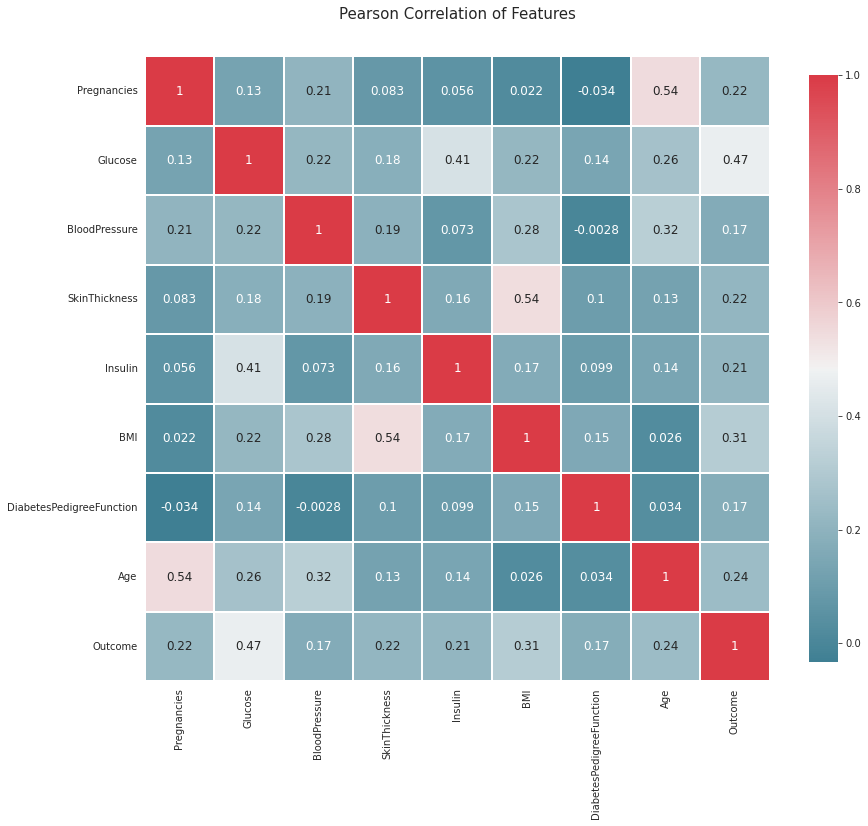

In [9]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data)

In [10]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

In [11]:
MLA_compare = pd.DataFrame()
MLA_predict = pd.DataFrame()
row_index = 0
for alg in MLA:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data[varNames], data[tarName], cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data[varNames], data[tarName])
    MLA_predict[MLA_name] = alg.predict(data[varNames])
    
    row_index+=1

#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

,MLA Name,MLA Parameters,MLA Time,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD
19,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.002918,0.771087,0.772727,0.070478
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.005936,0.770870,0.772294,0.077095
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.512029,0.768478,0.769697,0.077879
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.034600,0.787391,0.764069,0.075112
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.116066,1.000000,0.762771,0.065915
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.110652,0.949565,0.760173,0.047611
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.003155,0.763913,0.759307,0.090014
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.153190,1.000000,0.755844,0.070226
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.028683,0.761304,0.753680,0.059073
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.077398,0.852826,0.753247,0.028453


Text(0, 0.5, 'Algorithm')

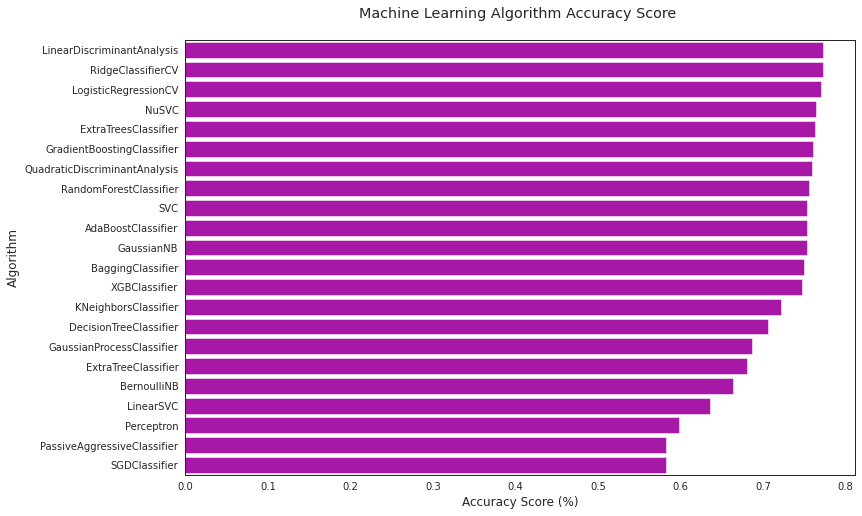

In [12]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [13]:
model = discriminant_analysis.LinearDiscriminantAnalysis()
model.fit(train_x,train_y)
predictions = model.predict(test_x)
#acc = predictions == test_y

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
print(predictions.shape)
predictions

(192,)


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [15]:
test_y.shape
ans = test_y.to_numpy().flatten()
print(ans.shape)

(192,)


In [16]:
acc = predictions == ans
sum = np.sum(acc)
print(f"accuracy is {sum/acc.shape[0]}")

accuracy is 0.78125


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    ## ROC-AUC 추가 
    #roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    #print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [18]:
print(ans)
print(predictions)
get_clf_eval(ans, predictions)

[0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0
 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1
 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0
 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0
 1 0 1 1 0 0 0]
[0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0
 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0]
오차 행렬
[[113  11]
 [ 31  37]]
정확도: 0.7812, 정밀도: 0.7708, 재현율: 0.5441,F1: 0.6379


In [19]:
pred_proba_class1 = model.predict_proba(test_x)[:,1]
print(pred_proba_class1)

[0.2279484  0.10916016 0.01326114 0.11823934 0.28002844 0.34183772
 0.04433673 0.99473868 0.96638789 0.20001657 0.28061251 0.15163731
 0.22867358 0.23750099 0.80825074 0.06180633 0.88229109 0.03848394
 0.702253   0.44639326 0.10398845 0.16080656 0.81929223 0.17797833
 0.75626831 0.85755946 0.09883783 0.55957728 0.9480752  0.11237731
 0.06513372 0.58530508 0.13696314 0.03907728 0.01351926 0.15746624
 0.2279913  0.97498762 0.32977947 0.08914387 0.209039   0.56153915
 0.28545505 0.07817813 0.09720719 0.17966014 0.28214335 0.34901384
 0.86883609 0.16648807 0.52628898 0.062799   0.57311643 0.20533781
 0.68562399 0.05626912 0.34739725 0.39296515 0.12871099 0.785005
 0.0535042  0.11467031 0.31265289 0.12239628 0.00379489 0.08842384
 0.21806097 0.21186122 0.29708653 0.47539692 0.0323601  0.68897026
 0.10839621 0.20083329 0.1024024  0.05957815 0.13867428 0.13046168
 0.32338696 0.17437682 0.45837332 0.5984887  0.90189086 0.35424035
 0.0429993  0.65182449 0.10333365 0.43802121 0.86246961 0.068267

In [20]:
fprs , tprs , thresholds = roc_curve(test_y, pred_proba_class1)

In [21]:
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값:  [0.99 0.79 0.59 0.47 0.35 0.34 0.3  0.26 0.18 0.1  0.03]
샘플 임곗값별 FPR:  [0.008 0.024 0.056 0.097 0.177 0.194 0.234 0.29  0.468 0.685 0.927]
샘플 임곗값별 TPR:  [0.    0.279 0.471 0.574 0.618 0.676 0.75  0.824 0.897 0.956 0.985]


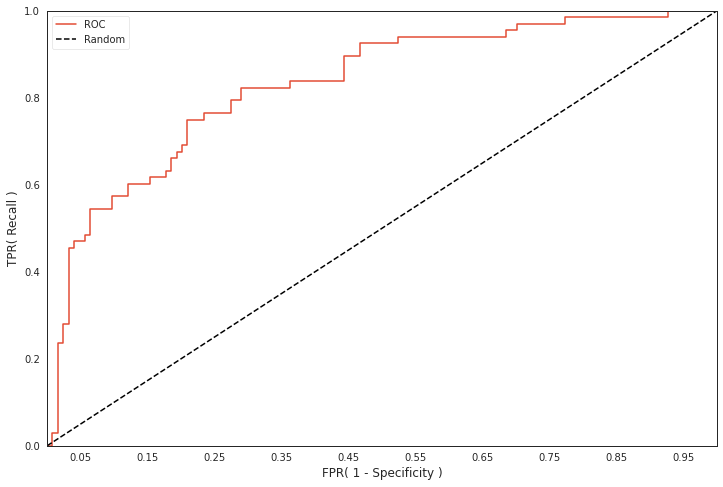

In [22]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Specificity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(test_y, model.predict_proba(test_x)[:, 1] )

In [23]:
pred_proba = model.predict_proba(test_x)[:,1]
roc_score = roc_auc_score(test_y, pred_proba)
print(f"roc score: {roc_score}")

roc score: 0.8312381404174572
